In [28]:
!unzip "/content/drive/My Drive/Stock Prices.zip" -d "/content/Stock Prices/"

Archive:  /content/drive/My Drive/Stock Prices.zip
replace /content/Stock Prices/AABA_2006-01-01_to_2018-01-01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/Stock Prices/AABA_2006-01-01_to_2018-01-01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Stock Prices/AABA_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/AXP_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/BA_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/CAT_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/CVX_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/DIS_2006-01-01_to_2018-01-01.csv  
  inflating: /content/Stock Prices/GE_2006-01-01_to_2018-01-01.csv  
  inflat

Load the Data

In [48]:
import pandas as pd

df = pd.read_csv("/content/Stock Prices/AAPL_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"])

df.drop(columns = ["Name"], inplace = True)

df

,Date,Open,High,Low,Close,Volume
0,2006-01-03,10.34,10.68,10.32,10.68,201853036
1,2006-01-04,10.73,10.85,10.64,10.71,155225609
2,2006-01-05,10.69,10.70,10.54,10.63,112396081
3,2006-01-06,10.75,10.96,10.65,10.90,176139334
4,2006-01-09,10.96,11.03,10.82,10.86,168861224
...,...,...,...,...,...,...
3014,2017-12-22,174.68,175.42,174.50,175.01,16349444
3015,2017-12-26,170.80,171.47,169.68,170.57,33185536
3016,2017-12-27,170.10,170.78,169.71,170.60,21498213
3017,2017-12-28,171.00,171.85,170.48,171.08,16480187


# Data Visualisation

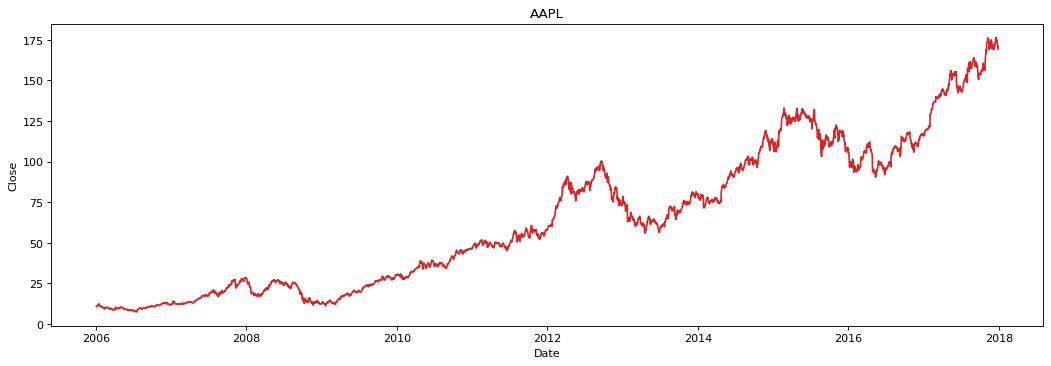

In [49]:
import matplotlib.pyplot as plt

x = df.Date

y = df.Close

plt.figure(figsize=(16,5), dpi = 80)

plt.plot(x, y, color='tab:red')

plt.gca().set(title = "AAPL", xlabel = "Date", ylabel = "Close")

plt.show()

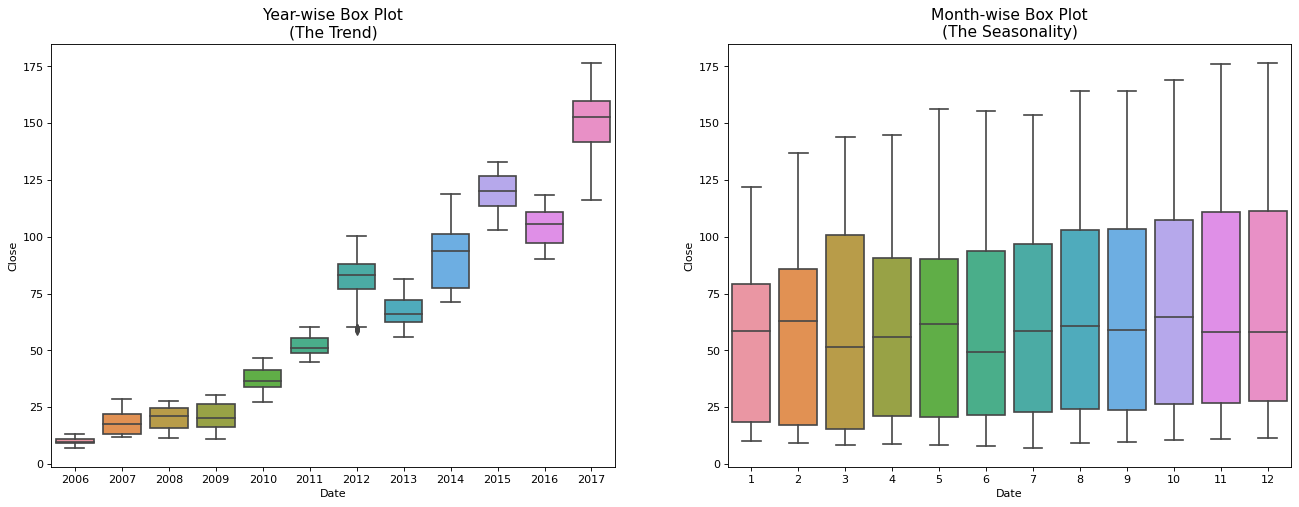

In [50]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)

# Yearly Boxplot

sns.boxplot(x = df.Date.dt.year, y='Close', data=df, ax=axes[0])

# Monthly Boxplot

sns.boxplot(x = df.Date.dt.month, y='Close', data=df)

# Set Titles

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=14); 

axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=14)

plt.show()

Decomposition

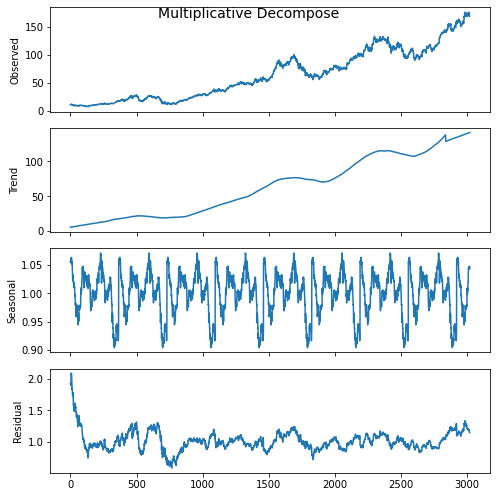

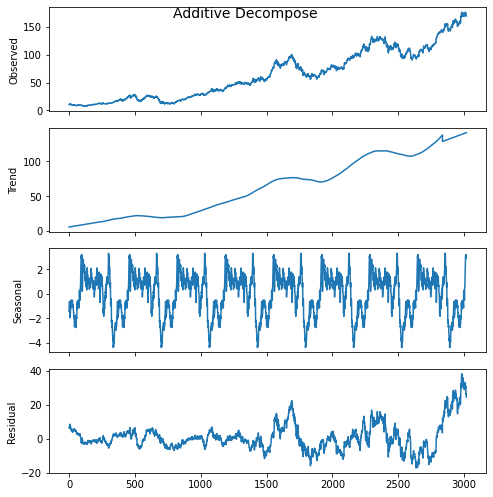

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 

result_mul = seasonal_decompose(y, model='multiplicative', extrapolate_trend='freq', freq=365)

# Additive Decomposition

result_add = seasonal_decompose(y, model='additive', extrapolate_trend='freq', freq=365)

# Plot

plt.rcParams.update({'figure.figsize': (7,7)})

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)

result_add.plot().suptitle('Additive Decompose', fontsize=14)

plt.show()

Check Stationarity

In [52]:
from statsmodels.tsa.stattools import adfuller

stats = adfuller(y.values, autolag='AIC')

output = pd.Series(stats[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


for key,value in stats[4].items():
    
    output['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller Test:')
    
print (output)

Results of Dickey-Fuller Test:
Test Statistic                    0.552367
p-value                           0.986381
#Lags Used                       22.000000
Number of Observations Used    2996.000000
Critical Value (1%)              -3.432535
Critical Value (5%)              -2.862505
Critical Value (10%)             -2.567284
dtype: float64


# Prophet Approach

In [53]:
# closing price for y and date for ds

train_data = pd.DataFrame()

train_data['ds'] = x.values

train_data['y'] = y.values

train_data.head()

,ds,y
0,2006-01-03,10.68
1,2006-01-04,10.71
2,2006-01-05,10.63
3,2006-01-06,10.90
4,2006-01-09,10.86


In [74]:
# Split Train-Val into 80-20

val_data = train_data[-round(len(train_data)*0.2):]

train_data = train_data[:-len(val_data)]

print(len(train_data), len(val_data))

2415 604


Hyperparameter Tuning

In [75]:
import itertools
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2007-09-18 00:00:00 and 2015-02-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f050fd7c898>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2007-09-18 00:00:00 and 2015-02-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f050fd7cac8>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2007-09-18 00:00:00 and 2015-02-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f050fe040f0>
INFO:fbprophet:Disabling daily seasonality. Run p

   changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.01                      0.1  16.498354
1                     0.01                      1.0  16.531736
2                     0.01                     10.0  16.642281
3                     0.10                      0.1  16.953968
4                     0.10                      1.0  16.917367
5                     0.10                     10.0  16.901599
6                     0.50                      0.1  17.125336
7                     0.50                      1.0  17.115995
8                     0.50                     10.0  17.129612


In [76]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


Train the Model

In [77]:
from fbprophet import Prophet

model = Prophet(changepoint_prior_scale = 0.01, 
                seasonality_prior_scale = 0.1)

model.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prediction

In [78]:
#predictions
future_prices = model.make_future_dataframe(periods=len(val_data))

forecast = model.predict(future_prices)

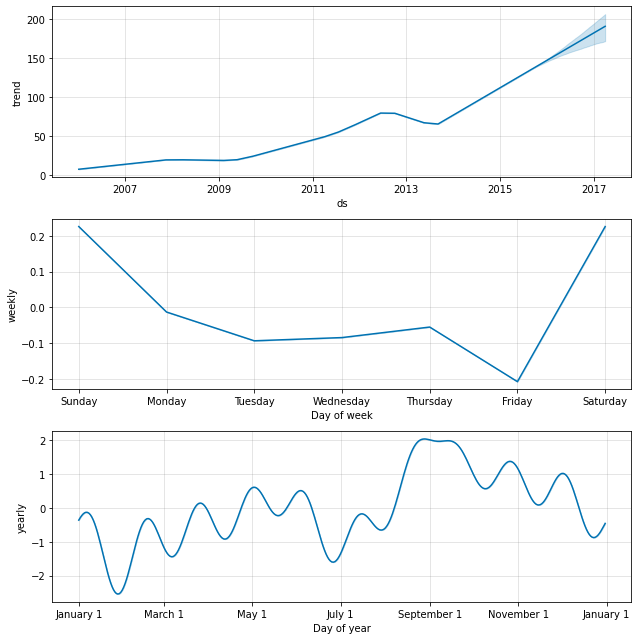

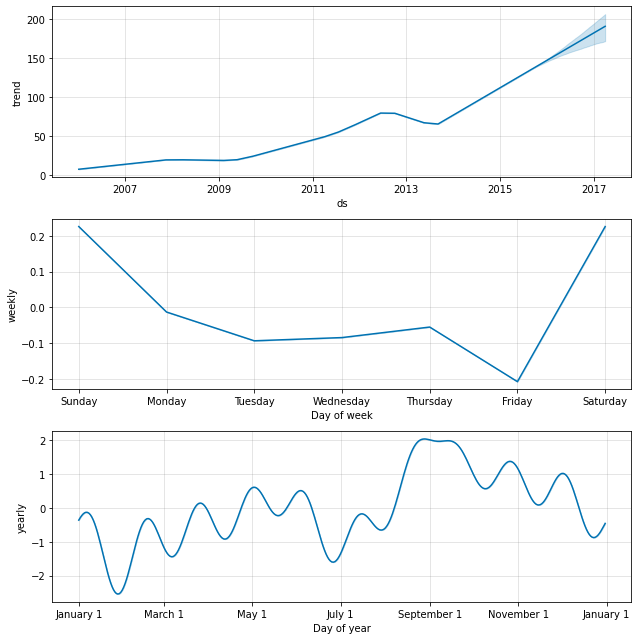

In [79]:
model.plot_components(forecast)

Evaluation

In [80]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-01-03,7.729147,0.806871,13.607351,7.729147,7.729147,-0.338734,-0.338734,-0.338734,-0.093170,-0.093170,-0.093170,-0.245564,-0.245564,-0.245564,0.0,0.0,0.0,7.390413
1,2006-01-04,7.746976,0.913459,13.848110,7.746976,7.746976,-0.277362,-0.277362,-0.277362,-0.084187,-0.084187,-0.084187,-0.193175,-0.193175,-0.193175,0.0,0.0,0.0,7.469614
2,2006-01-05,7.764804,0.969698,13.961890,7.764804,7.764804,-0.210077,-0.210077,-0.210077,-0.054776,-0.054776,-0.054776,-0.155301,-0.155301,-0.155301,0.0,0.0,0.0,7.554727
3,2006-01-06,7.782632,1.725653,14.123974,7.782632,7.782632,-0.341773,-0.341773,-0.341773,-0.207366,-0.207366,-0.207366,-0.134407,-0.134407,-0.134407,0.0,0.0,0.0,7.440860
4,2006-01-09,7.836117,1.260378,14.316908,7.836117,7.836117,-0.203745,-0.203745,-0.203745,-0.012729,-0.012729,-0.012729,-0.191016,-0.191016,-0.191016,0.0,0.0,0.0,7.632373


In [81]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

#rmse
forecast_valid = forecast.loc[len(train_data):,'yhat']

rmse = sqrt(mean_squared_error(forecast_valid, val_data['y']))

rmse

39.19684438354292

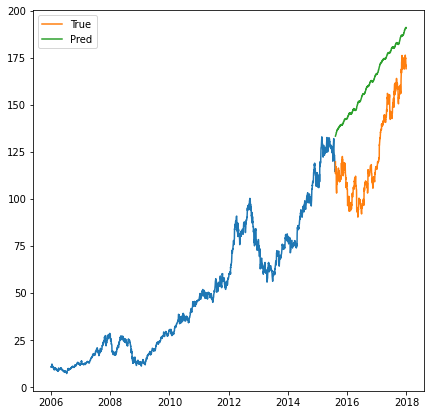

In [82]:
#plot
val_data['Predictions'] = 0
val_data['Predictions'] = forecast_valid.values

plt.plot(train_data['ds'], train_data['y'])
plt.plot(val_data['ds'], val_data['y'], label = "True")
plt.plot(val_data['ds'], val_data['Predictions'], label = "Pred")

plt.legend()
plt.show()

# SARIMAX Approach

In [54]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")

df_train = train_data.set_index(['ds'])

train_set = df_train[:'2017-05']
test_set = df_train['2017-06':]

train_set.shape, test_set.shape

((2871, 1), (148, 1))

Hyperparameter Tuning

In [16]:
p = d = q = range(5, 7)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [17]:
result_pdq = []
result_spdq = []
result_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train_set,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit()

            result_pdq.append(param)
            result_spdq.append(param_seasonal)
            result_aic.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:32688.488035815124
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:28855.16947259829
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15886.225942458508
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:15816.067895670989
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15828.060687874171
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:15818.196996301123
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:15818.37869340739
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:15803.725315261378
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:28768.328587879834
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:25044.238904091617
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13330.849874460562
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:13278.732711970417
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13297.87495583345
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:13319.50201708158
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:13286.45757844044
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:13274.762817476552
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8775.33206517906
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8751.356092036265


In [18]:
d = {'pdq': result_pdq, 'seasonal_pdq': result_spdq, 'AIC': result_aic}
df = pd.DataFrame(data=d)
df

,pdq,seasonal_pdq,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",32688.488036
1,"(0, 0, 0)","(0, 0, 1, 12)",28855.169473
2,"(0, 0, 0)","(0, 1, 0, 12)",15886.225942
3,"(0, 0, 0)","(0, 1, 1, 12)",15816.067896
4,"(0, 0, 0)","(1, 0, 0, 12)",15828.060688
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",8769.845444
60,"(1, 1, 1)","(1, 0, 0, 12)",8754.195147
61,"(1, 1, 1)","(1, 0, 1, 12)",8754.050174
62,"(1, 1, 1)","(1, 1, 0, 12)",9802.574489


In [19]:
# Best Params

df[df.AIC == df.AIC.min()]

,pdq,seasonal_pdq,AIC
36,"(1, 0, 0)","(1, 0, 0, 12)",8750.111198


Train the Model

In [55]:
model = sm.tsa.statespace.SARIMAX(train_set,
                                  order=(1, 0, 0),
                                  seasonal_order=(1, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0007      0.000   4647.243      0.000       1.000       1.001
ar.S.L12      -0.0102      0.015     -0.693      0.488      -0.039       0.019
sigma2         1.2481      0.015     84.591      0.000       1.219       1.277


Evaluation

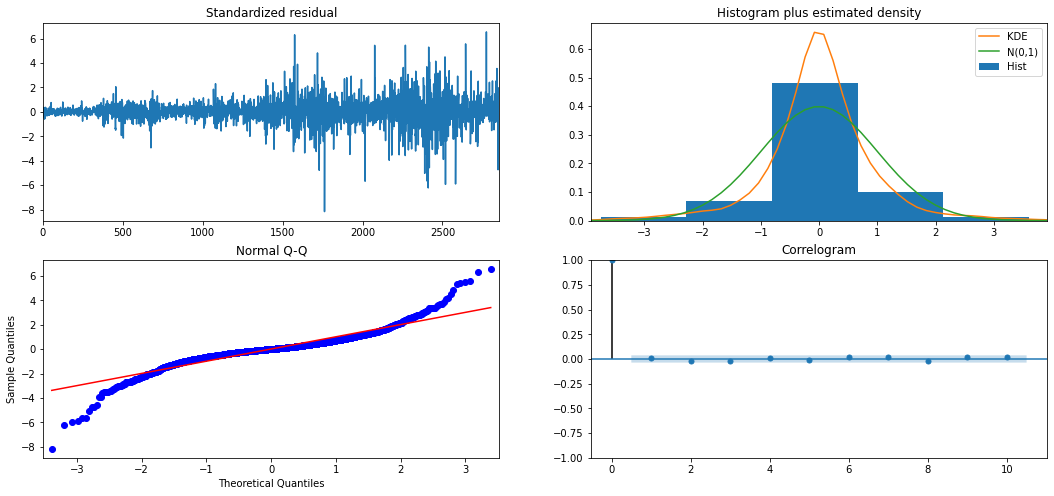

In [56]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

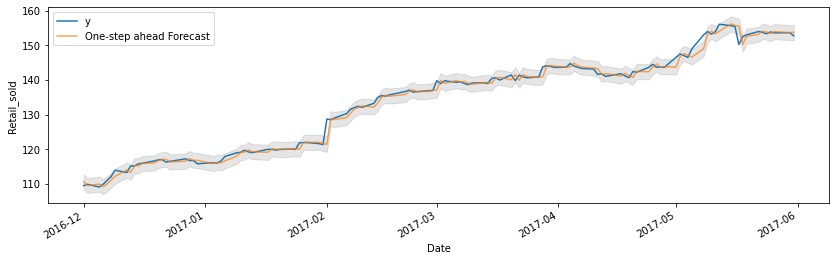

In [57]:
pred = results.get_prediction(start=pd.to_datetime('2016-12'), dynamic=False)
pred_ci = pred.conf_int()
ax = train_set['2016-12':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [58]:
y_forecasted = pred.predicted_mean
y_truth = train_set['2017':]
mse = ((y_forecasted - y_truth.y) ** 2).mean()

print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1.78
The Root Mean Squared Error is 1.34


Forecast

In [59]:
pred_uc = results.get_forecast(steps=len(test_set))

test_set['prediction'] = pred_uc.predicted_mean.values

pred_ci = pred_uc.conf_int()

pred_ci.set_index(test_set.index, inplace=True)

test_set = test_set.join(pred_ci, how='inner')

test_set

,y,prediction,lower y,upper y
ds,,,,
2017-06-01,153.18,152.866399,150.676737,155.056061
2017-06-02,155.45,152.971126,149.873450,156.068802
2017-06-05,153.93,153.127017,149.331896,156.922137
2017-06-06,154.45,153.206074,148.822394,157.589755
2017-06-07,155.37,153.303325,148.400595,158.206054
...,...,...,...,...
2017-12-22,175.01,168.102931,140.787645,195.418217
2017-12-26,170.57,168.214344,140.795165,195.633522
2017-12-27,170.60,168.325830,140.803015,195.848646


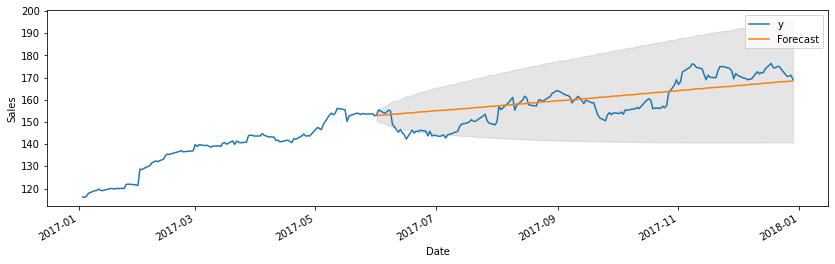

In [60]:
ax = df_train['2017':].plot(label='observed', figsize=(14, 4))
test_set['prediction'].plot(ax=ax, label='Forecast')
ax.fill_between(test_set.index,
                test_set['lower y'],
                test_set['upper y'], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

# LSTM Approach

In [51]:
df_new = pd.read_csv("/content/Stock Prices/AAPL_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"], index_col=['Date'])

df_new.drop(columns = ["Name"], inplace = True)

df_new

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036
2006-01-04,10.73,10.85,10.64,10.71,155225609
2006-01-05,10.69,10.70,10.54,10.63,112396081
2006-01-06,10.75,10.96,10.65,10.90,176139334
2006-01-09,10.96,11.03,10.82,10.86,168861224
...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444
2017-12-26,170.80,171.47,169.68,170.57,33185536
2017-12-27,170.10,170.78,169.71,170.60,21498213


In [52]:
train_set = df_new.loc[:'2016','Close'].values # 2006 to 2016
test_set = df_new.loc['2017':,'Close'].values # 2017

print(train_set.shape, test_set.shape)

(2768,) (251,)


In [53]:
# Predict 2018-01-01

# train_set = df_new['Close'].values
# test_set = df_new.iloc[-60:]['Close'].values

# print(train_set.shape, test_set.shape)

Normalise the Data

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(train_set_norm.shape)
print(train_set_norm)

(2768, 1)
[[0.02735369]
 [0.02759224]
 [0.02695611]
 ...
 [0.87086514]
 [0.87062659]
 [0.86339059]]


Creating Moving Window

In [55]:
import numpy as np

X_train = []
y_train = []

observ = 60 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(2708, 60, 1) (2708,)


In [56]:
total_test = df_new['Close'][-(len(test_set) + observ):].values # use the last 60 days of train to predict 1st day of test

test_set_norm = scaler.transform(total_test.reshape(-1,1))

test_set_norm.shape

(311, 1)

In [57]:
X_test = []
y_test = []

for i in range(observ, len(test_set_norm)):
  X_test.append(test_set_norm[i-observ:i])
  y_test.extend(test_set_norm[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape, y_test.shape)

(251, 60, 1) (251,)


Define Model

In [58]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128)(lstm_input)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('sigmoid')(x)
x = Dense(1)(x)

output = Activation('linear')(x)

model = Model(inputs=lstm_input, outputs=output)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                

In [59]:
model.compile(loss='mse', optimizer='adam')

Train Model

In [60]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=72,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/15
38/38 - 4s - loss: 0.0449 - val_loss: 0.0148
Epoch 2/15
38/38 - 3s - loss: 0.0183 - val_loss: 0.0501
Epoch 3/15
38/38 - 3s - loss: 0.0207 - val_loss: 0.0412
Epoch 4/15
38/38 - 3s - loss: 0.0185 - val_loss: 0.0364
Epoch 5/15
38/38 - 3s - loss: 0.0162 - val_loss: 0.0357
Epoch 6/15
38/38 - 3s - loss: 0.0085 - val_loss: 0.0279
Epoch 7/15
38/38 - 3s - loss: 0.0026 - val_loss: 0.0153
Epoch 8/15
38/38 - 3s - loss: 0.0029 - val_loss: 0.0169
Epoch 9/15
38/38 - 3s - loss: 0.0033 - val_loss: 0.0145
Epoch 10/15
38/38 - 3s - loss: 0.0017 - val_loss: 0.0132
Epoch 11/15
38/38 - 3s - loss: 0.0016 - val_loss: 0.0145
Epoch 12/15
38/38 - 3s - loss: 0.0018 - val_loss: 0.0115
Epoch 13/15
38/38 - 3s - loss: 0.0014 - val_loss: 0.0117
Epoch 14/15
38/38 - 3s - loss: 0.0013 - val_loss: 0.0106
Epoch 15/15
38/38 - 3s - loss: 0.0013 - val_loss: 0.0097


Visualisation

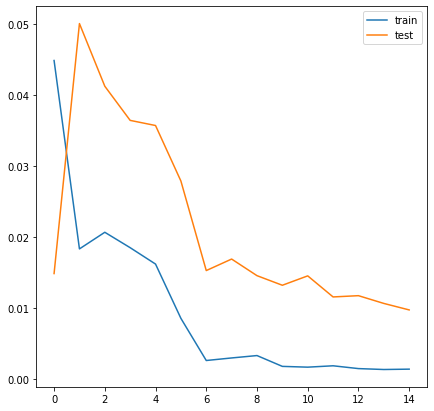

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.show()

Evaluation

In [62]:
y_pred = model.predict(X_test)

In [63]:
y_pred = scaler.inverse_transform(y_pred)

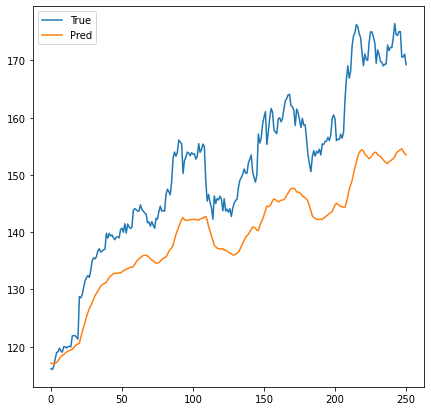

In [64]:
plt.plot(test_set, label = "True")
plt.plot(y_pred, label = "Pred")

plt.legend()
plt.show()

References:

*  https://www.machinelearningplus.com/time-series/time-series-analysis-python/

*  https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

*  https://medium.com/swlh/predicting-stock-prices-using-deep-learning-models-310b41cec90a

*  https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

*  https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

*  https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

*  https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

Add Technical Indicators

*  https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe
